# Histogram Standardization Testing for PET

For testing purpose, the standard scale used by the histogram mapping is set to [0,20]

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk

import sys
sys.path.append('../')
from datautils.visualization import NdimageVisualizer, display_image
from datautils.conversion import *

In [2]:
DATA_DIR = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFHN_rs113_hecktor_nii"
LANDMARKS_PATH = "../hecktor_meta/full_head_neck_crop/crFHN_rs113_train-hist_landmarks_PET.txt"
QUANTILES_CUTOFF = (0, 0.999) 

viz = NdimageVisualizer()

In [3]:

PATIENT_1 = "CHGJ008"
PET1_sitk = sitk.ReadImage(f"{DATA_DIR}/{PATIENT_1}_pt.nii.gz") # Shape (W,H,D): 450x450x90 voxels
PET1_np = sitk2np(PET1_sitk, keep_whd_ordering=True)

print("Min and Max SUV:", PET1_np.min(), PET1_np.max())
print("99.9 percentile:", np.percentile(PET1_np, 99.9))

Min and Max SUV: -5.0325503 71.97498
99.9 percentile: 11.008440050125188


In [4]:

PATIENT_2 = "CHUM010"
PET2_sitk = sitk.ReadImage(f"{DATA_DIR}/{PATIENT_2}_pt.nii.gz") # Shape (W,H,D): 450x450x90 voxels
PET2_np = sitk2np(PET2_sitk, keep_whd_ordering=True)

print("Min and Max SUV:", PET2_np.min(), PET2_np.max())
print("99.9 percentile:", np.percentile(PET2_np, 99.9))


Min and Max SUV: -0.0009519125 1.2605579
99.9 percentile: 0.7743905211687139


## Apply a threshold of 99.9 percentile and display

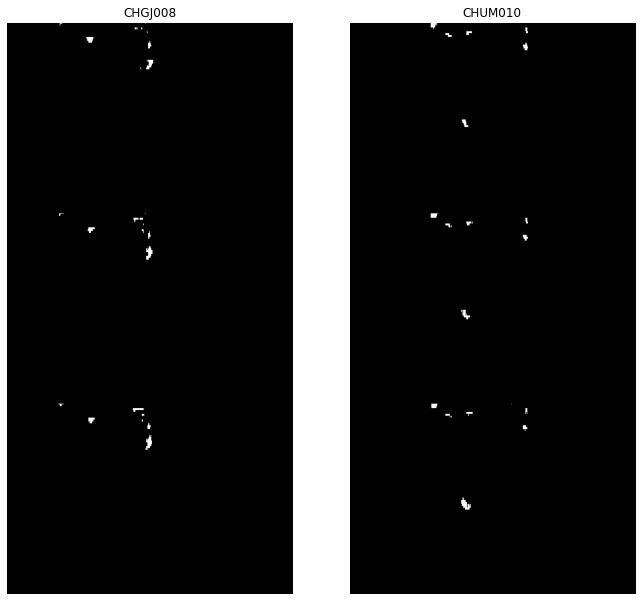

In [5]:
viz.multi_image_strips([PET1_np > np.percentile(PET1_np, 99.9), PET2_np > np.percentile(PET2_np, 99.9)],
                          modalities=['target-labelmap'] * 2,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=[PATIENT_1, PATIENT_2],
                          title="")


## Transform

In [8]:
def _get_percentiles(percentiles_cutoff):
        quartiles = np.arange(25, 100, 25).tolist()
        deciles = np.arange(10, 100, 10).tolist()
        all_percentiles = list(percentiles_cutoff) + quartiles + deciles
        percentiles = sorted(set(all_percentiles))
        return np.array(percentiles)

def histogram_transform(image_np, landmarks, quantiles_cutoff, epsilon=1e-5):
        quantiles_cutoff = quantiles_cutoff
        mapping = landmarks
        shape = image_np.shape
        image_np = image_np.reshape(-1).astype(np.float32)

        range_to_use = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12]

        percentiles_cutoff = 100 * np.array(quantiles_cutoff)
        percentiles = _get_percentiles(percentiles_cutoff)
        percentile_values = np.percentile(image_np, percentiles)

        # Apply linear histogram standardization
        range_mapping = mapping[range_to_use]
        range_perc = percentile_values[range_to_use]
        diff_mapping = np.diff(range_mapping)
        diff_perc = np.diff(range_perc)

        # Handling the case where two landmarks are the same
        # for a given input image. This usually happens when
        # image background is not removed from the image.
        diff_perc[diff_perc < epsilon] = np.inf

        affine_map = np.zeros([2, len(range_to_use) - 1])

        # Compute slopes of the linear models
        affine_map[0] = diff_mapping / diff_perc

        # Compute intercepts of the linear models
        affine_map[1] = range_mapping[:-1] - affine_map[0] * range_perc[:-1]

        bin_id = np.digitize(image_np, range_perc[1:-1], right=False)
        lin_img = affine_map[0, bin_id]
        aff_img = affine_map[1, bin_id]
        new_img = lin_img * image_np + aff_img
        new_img = new_img.reshape(shape)
        new_img = new_img.astype(np.float32)
        return new_img
    

### Transform and display using a given SUV window

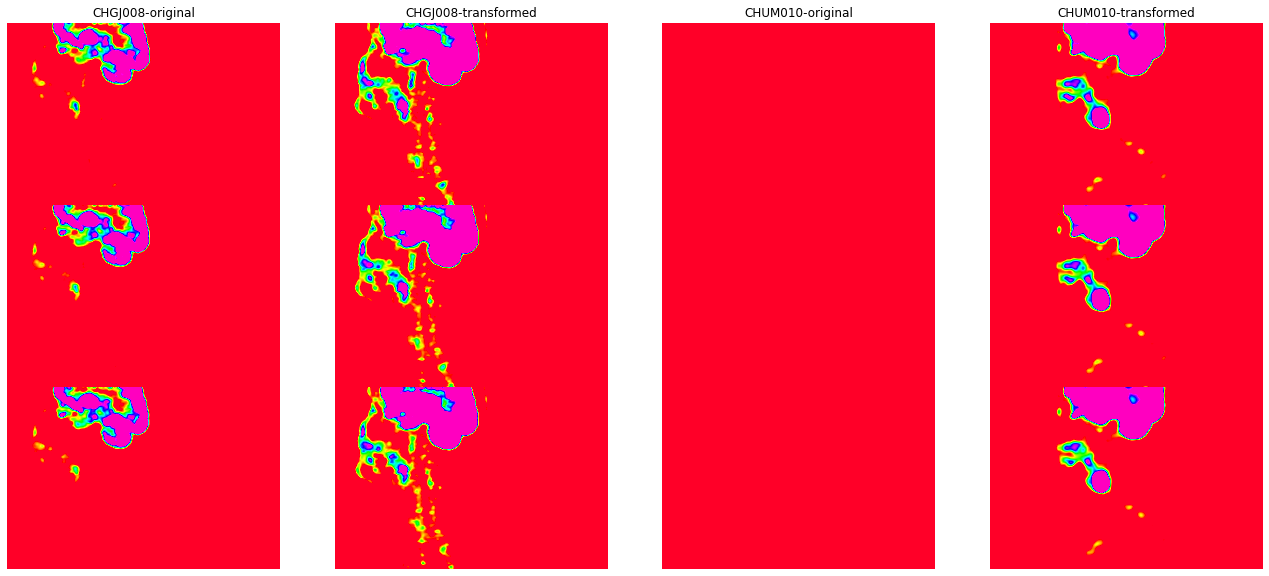

In [20]:
landmarks = np.loadtxt(LANDMARKS_PATH)

# Transform
PET1_tfm_np = histogram_transform(PET1_np, landmarks, QUANTILES_CUTOFF)
PET2_tfm_np = histogram_transform(PET2_np, landmarks, QUANTILES_CUTOFF)

# Dispay
window = {'level': 5, 'width': 5}

viz.set_suv_window(window)
viz.multi_image_strips([PET1_np, PET1_tfm_np, PET2_np, PET2_tfm_np],
                          modalities=['PET'] * 4,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=[f"{PATIENT_1}-original", f"{PATIENT_1}-transformed", f"{PATIENT_2}-original", f"{PATIENT_2}-transformed",],
                          title="")